In [402]:
!pip3 install -q torch_geometric

In [403]:
import numpy as np
import math
from pprint import pprint

import torch
from torch.utils.data import IterableDataset
from torch.utils.data import DataLoader as torchDataLoader
import torch.nn.functional as F

import torch_geometric
from torch_geometric.data import Data, Batch, DataLoader, InMemoryDataset, download_url 
from torch_geometric.utils import erdos_renyi_graph, to_dense_adj, dense_to_sparse, to_networkx, from_networkx
from torch_geometric.nn import GCNConv

import networkx as nx
import matplotlib.pyplot as plt
import os

In [404]:
print("torch_geometric version:", torch_geometric.__version__)
print("torch version:", torch.__version__)

torch_geometric version: 2.6.1
torch version: 2.6.0+cu124


## Creating datasets for training

## Erdos renyi dataset

In [405]:
def generate_erdos_renyi_graphData(num_nodes=5, p=0.8):
    edge_tensor = erdos_renyi_graph(num_nodes, p, directed=False)  # shape [2, num_edges]

    # Create graph nodes, values all 0
    nodes = torch.zeros((num_nodes, 1)) # shape [num_nodes, 1], any node feature is a single scalar 0.
    # each node in this tensor is assigned an id based on its index 0...num_nodes-1 
    # these ids are the ones used in edge_tensor, it is possible that there are no edges... 
    
    # Create Data object for graph
    graphData = Data(x=nodes, edge_index=edge_tensor)
    
    return graphData

graphDataset = generate_erdos_renyi_graphData()
# G = to_networkx(graph, to_undirected=True)
# plt.figure()
# nx.draw(G, with_labels=True, node_size=500)
# plt.show()

In [406]:
# inspiration from https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html#creating-in-memory-datasets

class ErdosRenyiDataset(InMemoryDataset):
    def __init__(self, root, num_graphs=100, transform=None, pre_transform=None, pre_filter=None):
        self.num_graphs = num_graphs

        super().__init__(root, transform, pre_transform, pre_filter)

        # Generate dataset if not done already, else load it
        processed_path = self.processed_paths[0]
        if not os.path.exists(processed_path):
            print("Creating dataset")
            self.process()
        else:
            print("Dataset already exists, loading it...")

        self.load(self.processed_paths[0]) # populates self.data
        print("Done.")

        """
        self.load will create objects:
        
        self.slices = {
          'x':          tensor([0, 2, 5, 6]),   # node feature offsets
          'edge_index': tensor([0, 1, 3, 4]),   # edge index offsets
        }

        self.data = {
          'x':          (total_num_nodes, num_node_features) # concatenation of all graphs nodes
          'edge_index': (2, total_num_edges) # concatenation of all graph edges
        }
        """

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        data_list = []

        for i in range(self.num_graphs):
            data_list.append(generate_erdos_renyi_graphData())

        if self.pre_filter:
            data_list = [d for d in data_list if self.pre_filter(d)]
            
        if self.pre_transform:
            data_list = [self.pre_transform(d) for d in data_list]

        self.save(data_list, self.processed_paths[0]) # Runs: data, slices = cls.collate(data_list) and saves these objects

In [407]:
!rm -rf /kaggle/working/data/ER/processed
erdos_renyi_dataset = ErdosRenyiDataset(root='data/ER', num_graphs=100)

Dataset already exists, loading it...
Done.


Processing...
Done!


In [408]:
print(f"Number of graphs: {len(erdos_renyi_dataset)}")

for g in range(4):
    edge_index = erdos_renyi_dataset[g].edge_index

Number of graphs: 100


In [409]:
edge_index[:, :1]

tensor([[0],
        [1]])

## Planar graph dataset generated using plantri

Command             | Triangulations Written | CPU Time (sec)
--------------------|------------------------|---------------
./plantri -c3 10    | 233                    | 0.00
./plantri -c3 11    | 1,249                  | 0.02
./plantri -c3 12    | 7,595                  | 0.04
./plantri -c3 13    | 49,566                 | 0.16
./plantri -c3 14    | 339,722                | 1.11
./plantri -c3 15    | 2,406,841              | 8.01
./plantri -c3 16    | 17,490,241             | 61.98
./plantri -c3 17    | 129,664,753            | 504.53

In [410]:
import networkx as nx

def graph6_to_data(g6_path):
    print(f"Loading graphs from {g6_path}")
    
    with open(g6_path, "rb") as f:
        graph_nx = nx.read_graph6(f)

    print(f"Read {len(graphs_nx)} graphs from {g6_path}")
    return graphs_nx

In [411]:
# inspiration from https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html#creating-in-memory-datasets

class PlanarDataset(InMemoryDataset):
    def __init__(self, root, g6_dir=None, transform=None, pre_transform=None, pre_filter=None):

        g6_files = [os.path.join(g6_dir, f) for f in os.listdir(g6_dir) if f.endswith(".g6")]
        self.g6_files = g6_files
        
        super().__init__(root, transform, pre_transform, pre_filter)

        # Generate dataset if not done already, else load it
        processed_path = self.processed_paths[0]
        if not os.path.exists(processed_path):
            print("Creating dataset")
            self.process()
        else:
            print("Dataset already exists, loading it...")

        self.load(self.processed_paths[0]) # populates self.data
        print("Done.")

        """
        self.load will create objects:
        
        self.slices = {
          'x':          tensor([0, 2, 5, 6]),   # node feature offsets
          'edge_index': tensor([0, 1, 3, 4]),   # edge index offsets
        }

        self.data = {
          'x':          (total_num_nodes, num_node_features) # concatenation of all graphs nodes
          'edge_index': (2, total_num_edges) # concatenation of all graph edges
        }
        """

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        data_list = []

        for file in self.g6_files:
            nx_graphs = graph6_to_data(file)
            data_list += [from_networkx(g) for g in nx_graphs]

        if self.pre_filter:
            data_list = [d for d in data_list if self.pre_filter(d)]
            
        if self.pre_transform:
            data_list = [self.pre_transform(d) for d in data_list]

        self.save(data_list, self.processed_paths[0]) # Runs: data, slices = cls.collate(data_list) and saves these objects

In [412]:
#planar_dataset = PlanarDataset(root='data/PL', g6_dir="/kaggle/input/planar-graphs-g6-dataset")

# Model definition

In [413]:
def get_cost(): # can also be based on G0, P1...P{l-1}
    return np.random.rand() 

# test
get_cost()

0.19660520178382956

tensor([[0, 1],
        [0, 2],
        [0, 3],
        [0, 4],
        [1, 0],
        [1, 2],
        [1, 3],
        [1, 4],
        [2, 0],
        [2, 1]])
Total number of nodes: 5


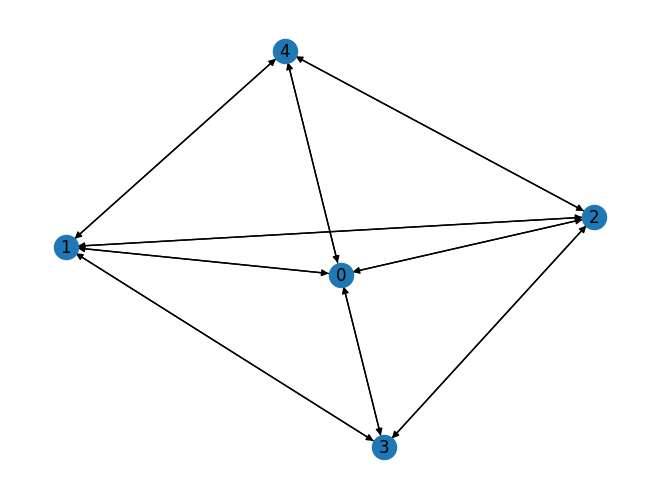

In [414]:
def get_candidate_contraction_sets(G: Data):
    # make sure no self loop on nodes here!
    edge_index = G.edge_index # 2, num_edges (tensor)
    u, v       = edge_index[0], edge_index[1]

    # remove self edges
    nonself = (u != v)
    u_ns, v_ns = u[nonself], v[nonself]

    candidates = torch.stack([u_ns, v_ns], dim=1)
    return candidates

# test
test_graph = erdos_renyi_dataset[10]
nx.draw(to_networkx(test_graph), with_labels=True)

test_candidates = get_candidate_contraction_sets(test_graph)
print(test_candidates[:10])

test_current_num_nodes = test_graph.num_nodes
print("Total number of nodes:", test_current_num_nodes)

In [415]:
def rnd_greedy_min_cost_part(
    candidate_contractions: torch.LongTensor, 
    cost_function, 
    num_nodes_to_remove: int, 
    current_num_nodes: int,
    rand_lambda: float = 1.0
):
    """
    Algo 2
    candidate_contractions [num_candidates, 2] each candidate is a pair of nodes (edge)
    Greedily picks contraction candidates until at least num_nodes_to_remove are merged.
    """

    num_candidates = candidate_contractions.size(0)    
    alive = torch.ones(num_candidates, dtype=torch.bool) # check for already selected contractions, True means not selected
    marked  = torch.zeros(current_num_nodes, dtype=torch.bool) # mark nodes already contracted...
    costs  = torch.tensor([cost_function() for _ in range(num_candidates)], dtype=torch.float32)
    # each cost is a rand float between 0 and 1    

    picked = [] # picked contractions idx
    removed = 0
    
    while (removed < num_nodes_to_remove and alive.any()):
        masked_costs = costs.masked_fill(~alive, float('inf'))
        idx = torch.argmin(masked_costs).item()
        
        if torch.rand(1).item() > rand_lambda: # simulate Bernoulli
            alive[idx] = False
            continue 

        selected_nodes = candidate_contractions[idx]
        
        if marked[selected_nodes].any():
            alive[idx] = False
            continue
        
        marked[selected_nodes] = True   
        alive[idx] = False
        picked.append(idx)        
        removed +=  selected_nodes.numel() - 1 # merging always keeps one node

    if picked:
        picked_idx = torch.tensor(picked, dtype=torch.long)
        return candidate_contractions[picked_idx]
    else:
        print("rnd_greedy_min_cost_part Error")

# test
# for remove_n in range(1, current_num_nodes // 2): # max number of removable nodes
#     test_partitioning = rnd_greedy_min_cost_part(test_candidates, get_cost, remove_n, current_num_nodes)
#     print(f"Removed {remove_n} nodes with contractions: {test_partitioning}")
    
test_num_nodes_to_remove = 2
test_partitioning = rnd_greedy_min_cost_part(test_candidates, get_cost, test_num_nodes_to_remove, test_current_num_nodes)
print(test_partitioning)

tensor([[1, 0],
        [2, 3]])


In [416]:
def visualize_clusters(G: Data, partitioning: torch.Tensor):
    # Convert to NetworkX
    G_nx = to_networkx(G, to_undirected=True)

    # Create a color map for each node
    color_map = ['lightgray'] * G.num_nodes  # default color

    # Assign a unique color for each cluster
    colors = [
        'red', 'green', 'blue', 'orange', 'purple', 'cyan', 'yellow', 'brown',
        'pink', 'olive', 'chocolate', 'lime', 'navy', 'teal', 'coral', 'gold',
        'magenta', 'orchid', 'salmon', 'darkgreen', 'deepskyblue', 'slateblue',
        'violet', 'maroon', 'turquoise', 'indigo', 'darkorange', 'crimson',
        'steelblue', 'darkviolet', 'khaki', 'cadetblue', 'hotpink', 'mediumseagreen'
    ]

    cluster_id_to_color = {}
    
    for cluster_id, cluster in enumerate(partitioning):
        color = colors[cluster_id % len(colors)]
        cluster_id_to_color[cluster_id] = color
        for node in cluster.tolist():
            color_map[node] = color
        print(f"Cluster {cluster_id} has color {colors[cluster_id % len(colors)]}")

    # Draw the graph
    pos = nx.spring_layout(G_nx, seed=42)
    nx.draw(G_nx, pos, node_color=color_map, with_labels=True, edge_color="gray")
    plt.show()

    return cluster_id_to_color

Cluster 0 has color red
Cluster 1 has color green


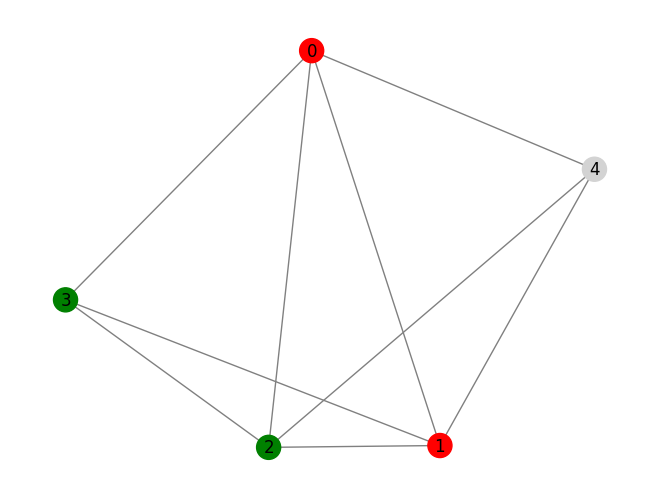

Cluster 0 has color red


In [417]:
test_cluster_id_to_color = visualize_clusters(test_graph, test_partitioning)
print(f"Cluster 0 has color {test_cluster_id_to_color[0]}")

In [418]:
def has_edge_undirected(edge_index, u, v):
    src, dst = edge_index
    return ((src == u) & (dst == v)).any() or ((src == v) & (dst == u)).any()

has_edge_undirected(graph.edge_index, 3, 5)

tensor(False)

In [419]:
def augment_with_singletons(partitioning: torch.LongTensor, num_nodes: int, debug=False):
    """
    Given partitioning of shape [P,2] (or [P,K] with padding=-1),
    return a new LongTensor of shape [P+U, K'] where rows 0..P-1
    are your old clusters, and rows P..P+U-1 each contain exactly
    one leftover node as a single cluster.
    """
    # flatten and find which nodes were clustered
    clustered = partitioning.unique() # no dim specified -> unique of the flattened partitioning
    num_initial_clusters = partitioning.shape[0]
    
    all_nodes = torch.arange(num_nodes, device=partitioning.device)
    
    mask = torch.ones(num_nodes, dtype=torch.bool, device=partitioning.device)
    mask[clustered] = False
    
    leftover = all_nodes[mask]  # shape [U]

    # now make each leftover its own cluster of size 1, with itself, little trick
    singletons = torch.stack([leftover, leftover], dim=1) # [U, 2]
    
    if singletons.numel() > 0:
        partitioning = torch.cat([partitioning, singletons], dim=0)

        if debug:
            for i, node_id in enumerate(leftover.tolist()):
                cluster_id = num_initial_clusters + i
                print(f"Leftover node {node_id} assigned to singleton cluster {cluster_id}")

    return partitioning # ideally also explain what id each solo cluster got for coloring later!

# test 
print(f"Number of clusters before: {test_partitioning.shape[0]}")
test_augmented_partitioning = augment_with_singletons(test_partitioning, test_current_num_nodes, debug=True)
print(f"Number of clusters after: {test_augmented_partitioning.shape[0]}")

Number of clusters before: 2
Leftover node 4 assigned to singleton cluster 2
Number of clusters after: 3


In [420]:
def build_P(num_nodes: int,
            partitioning: torch.Tensor):
    """
    num_nodes: N
    partitioning: list of LongTensors, each contains original node‑indices cluster.
    Returns P of shape [num_coarse, N], where P[c,i]=1 if i belongs to coarse‑node c.
    """
    num_clusters = len(partitioning)

    P = torch.zeros((num_clusters, num_nodes), dtype=torch.float32)
    for c, nodes in enumerate(partitioning):
        P[c, nodes] = 1.0
    return P

# test
test_P = build_P(test_current_num_nodes, test_augmented_partitioning)
print(test_P)

tensor([[1., 1., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 1.]])


Each row corresponds to one cluster id, each column corresponds to one node. This can be reused to compute the expansion step GT as each cluster super node will need to be expanded back to however many nodes it contains.

In [421]:
def get_graph_adj(edge_index: torch.LongTensor, num_nodes: int):
    adj = to_dense_adj(edge_index, max_num_nodes=num_nodes)
    adj = adj[0]
    return adj

# test
test_graph_adj = get_graph_adj(test_graph.edge_index, test_current_num_nodes)
#indices = (graph_adj == 1).nonzero(as_tuple=False)
print(test_graph_adj)

tensor([[0., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1.],
        [1., 1., 0., 1., 1.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0.]])


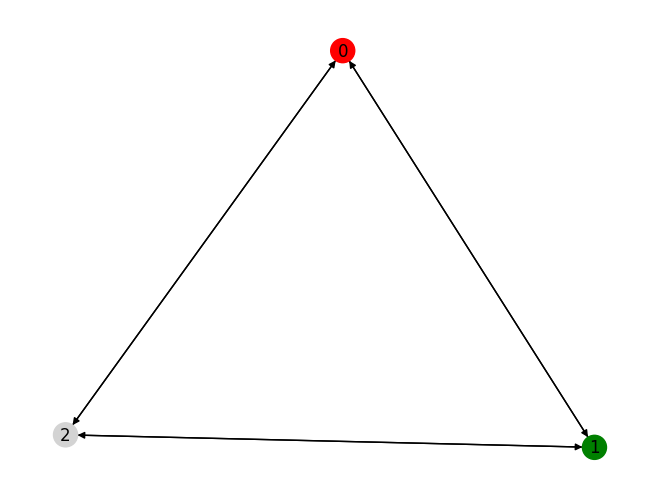

In [422]:
def coarsen_graph(G: Data, partitioning: torch.LongTensor):
    """
    Merge each row of partitioning into a single super‐node.
    Unclustered nodes are nodes j not appearing in any row of partitioning.
    Edges between any two super‐nodes exist iff any member nodes in both were previously connected in G.
    G{l}->G{l+1}
    """
    
    N = G.num_nodes

    augmented_partitioning = augment_with_singletons(partitioning, N)
    
    P = build_P(N, augmented_partitioning) # map nods to clusters
    graph_adj = get_graph_adj(G.edge_index, N) # get initial graph adjency
    cluster_adj = get_cluster_adj(P, graph_adj)

    edge_index, edge_attr = dense_to_sparse(cluster_adj)
    num_coarse = cluster_adj.size(0)
    
    x = torch.zeros((num_coarse, 1), dtype=torch.float32)
    return Data(x=x, edge_index=edge_index, num_nodes=num_coarse), P

# test
test_coarsened_graph, test_P = coarsen_graph(test_graph, test_partitioning)

def get_coarse_node_colors(num_clusters: int, cluster_id_to_color: dict) -> list[str]:
    """
    Returns a list of colors for super-nodes in the coarsened graph.
    Each super-node corresponds to a cluster ID.
    """
    color_map = []
    for cluster_id in range(num_clusters):
        color = cluster_id_to_color.get(cluster_id, 'lightgray')
        color_map.append(color)
    return color_map

test_num_clusters = test_coarsened_graph.num_nodes
test_coarse_colors = get_coarse_node_colors(test_num_clusters, test_cluster_id_to_color)

# Step 3: Plot the coarsened graph
nx.draw(to_networkx(test_coarsened_graph), with_labels=True, node_color=test_coarse_colors)

In [423]:
def get_cluster_adj(P: torch.FloatTensor,
                        A: torch.FloatTensor):
    # P: [C, N]; A: [N, N]
    M = P @ A @ P.t()       # [C, C], computes inter cluster links
    M.fill_diagonal_(0)
    return (M > 0).to(torch.float32)

# test
test_cluster_adj = get_cluster_adj(test_P, test_graph_adj)
print(test_cluster_adj)

tensor([[0., 1., 1.],
        [1., 0., 1.],
        [1., 1., 0.]])


In [424]:
curr = 1
for i in range(10):
    print(curr)
    curr = curr-math.ceil(0.10*curr)

1
0
0
0
0
0
0
0
0
0


In [425]:
def rnd_red_seq(G0: Data, min_red_frac=0.1, max_red_frac=0.3, debug=False): # it is not possible to remove more than current_num_nods//2 with edge contraction
    """
    Algo 1
    Returns random coarsening sequence π = (G0, . . . , GL) ∈ ΠF (G) 
    """

    current_graph = G0
    
    if debug: print(f"Initial graph has {G0.num_nodes} nodes.")
    coarsening_seq = [current_graph] # π, will end up containing (G0...GL)
    l = 0

    contractions_history = [] # will contain (P1...PL-1) where Pi is the partitioning matrix used to coarsen Gi into G{i+1}
    
    while current_graph.num_nodes != 1: # removing % of current_num_nods to current_num_nods will always be bigger than 0 and math.ceil 
        # will end up being one until current_num_nods becomes 1 -> last node will be removed 
        l += 1
        reduction_fraction = torch.tensor([1.0])
        reduction_fraction.uniform_(min_red_frac, max_red_frac)  # ρ

        # f already defined as get_cost, for now does not depend on G0/contractions_history
        num_nodes_to_remove = math.ceil(reduction_fraction * current_graph.num_nodes) # m

        candidates = get_candidate_contraction_sets(current_graph) # F(G{l−1}) fetch all possible contractions
        if candidates.numel() == 0:
            print("Error no more edges to contract in rnd_red_seq")
            break
        
        partitioning_l = rnd_greedy_min_cost_part(
            candidate_contractions=candidates,
            cost_function=get_cost,
            num_nodes_to_remove=num_nodes_to_remove,
            current_num_nodes=current_graph.num_nodes,
        ) # tensor [C0, C1, …, Ck] # [num_clusters, 2]

        if partitioning_l.numel() == 0:
            print("No contractions picked")
            continue

        # coarsen graph
        if debug: print(f"Coarsening graph and removing {num_nodes_to_remove} nodes.")
        current_graph, P = coarsen_graph(current_graph, partitioning_l)
        coarsening_seq.append(current_graph)
        contractions_history.append(P) 

    return coarsening_seq, contractions_history

# test
test_coarsening_seq, test_contractions_history = rnd_red_seq(test_graph)
print(len(test_coarsening_seq), len(test_contractions_history))

print("\nCoarsening sequence:")
pprint(test_coarsening_seq)

print("\nContractions history:")
pprint(test_contractions_history)

5 4

Coarsening sequence:
[Data(x=[5, 1], edge_index=[2, 18]),
 Data(x=[4, 1], edge_index=[2, 12], num_nodes=4),
 Data(x=[3, 1], edge_index=[2, 6], num_nodes=3),
 Data(x=[2, 1], edge_index=[2, 2], num_nodes=2),
 Data(x=[1, 1], edge_index=[2, 0], num_nodes=1)]

Contractions history:
[tensor([[0., 0., 1., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.]]),
 tensor([[1., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 tensor([[0., 1., 1.],
        [1., 0., 0.]]),
 tensor([[1., 1.]])]


## Defining coarsened graphs dataset

In [426]:
for g in erdos_renyi_dataset[0:5]:
    print(g)

Data(x=[5, 1], edge_index=[2, 18])
Data(x=[5, 1], edge_index=[2, 16])
Data(x=[5, 1], edge_index=[2, 16])
Data(x=[5, 1], edge_index=[2, 16])
Data(x=[5, 1], edge_index=[2, 18])


In [427]:
def compute_node_embeddings(P):
    return P.sum(dim=1).long() # v_l

# test
print("P:")
print(test_P)
print("Result:", compute_node_embeddings(test_P))

P:
tensor([[1., 1., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 1.]])
Result: tensor([2, 2, 1])


In [428]:
def expand_coarsened(Gc: Data, P):
    v = compute_node_embeddings(P) 
    C, N = P.shape
    expanded_adj = np.zeros((N, N), dtype=int)
    
    coarsened_adj = get_graph_adj(Gc.edge_index, Gc.num_nodes) # [C, C]

    # for each node i find its cluster id
    clusters = P.argmax(dim=0)  # [N]  each in 0..C-1

    # # intercluster connections 
    # for i in range(N):
    #     for j in range(N):
    #         if clusters[i] != clusters[j]:
    #             ci, cj = clusters[i], clusters[j]
    #             if coarsened_adj[ci, cj] == 1:
    #                 expanded_adj[i, j] = 1
    #                 expanded_adj[j, i] = 1
    #         else:
    #             expanded_adj[i, j] = 1
    #             expanded_adj[j, i] = 1

    # np.fill_diagonal(expanded_adj, 0)
    # return expanded_adj
    
    # chatgpt optimized version using broadcasting
    idx_i = clusters.unsqueeze(1)  # [N,1]
    idx_j = clusters.unsqueeze(0)  # [1,N]

    # intercluster mask
    inter_mask = coarsened_adj[idx_i, idx_j].to(torch.int) # [N, N] 
    
    # intracluster mask
    intra_mask = idx_i == idx_j.to(torch.int) # [N, N]

    # combine and zero out diagonal no self loop
    expanded = (inter_mask | intra_mask)
    expanded.fill_diagonal_(False)

    return expanded
    
# test
test_expanded_graph_adj = expand_coarsened(test_coarsened_graph, test_P)
print(test_expanded_graph_adj)

tensor([[0, 1, 1, 1, 1],
        [1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1],
        [1, 1, 1, 1, 0]], dtype=torch.int32)


Original clustering
Cluster 0 has color red
Cluster 1 has color green


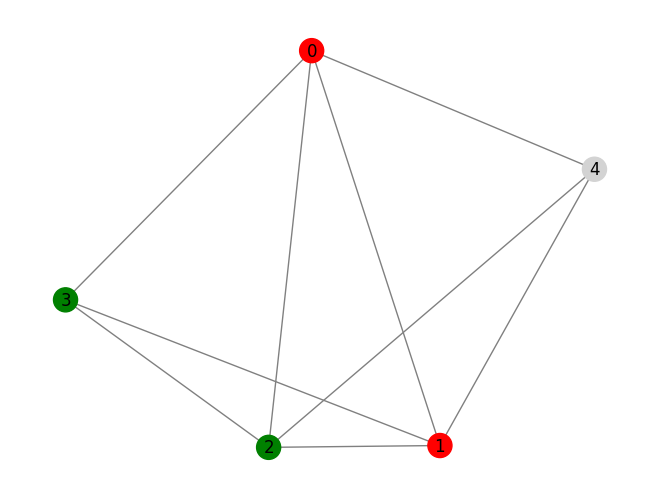

In [429]:
print("Original clustering")
test_cluster_id_to_color = visualize_clusters(test_graph, test_partitioning)

In [430]:
test_cluster_id_to_color

{0: 'red', 1: 'green'}

Original coarsened graph


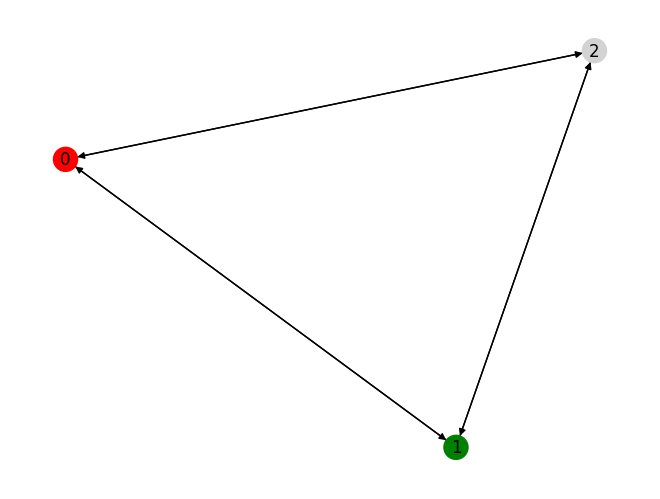

In [431]:
print("Original coarsened graph")
nx.draw(to_networkx(test_coarsened_graph), with_labels=True, node_color=test_coarse_colors)

In [432]:
def compute_edge_embeddings(expanded_adj: torch.Tensor, original_adj: torch.Tensor) -> Data:
    """
    expanded_adj: [N, N] dense adjacency (0/1)
    expanded_adj: [N, N] dense adjacency (0/1)
    
    returns: Data(x=[N,1], edge_index=[2, E])
    """
    edge_index, edge_attr = dense_to_sparse(expanded_adj)
    edge_labels = original_adj[edge_index[0],edge_index[1]].long() # [E]
    
    x = torch.zeros((expanded_adj.size(0), 1), dtype=torch.float)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_labels)

test_expandedGraphData = compute_edge_embeddings(test_expanded_graph_adj, test_graph_adj)
print(test_expandedGraphData)

Data(x=[5, 1], edge_index=[2, 20], edge_attr=[20])


Expanded graph coarsened graph
Cluster 0 has color red
Cluster 1 has color green


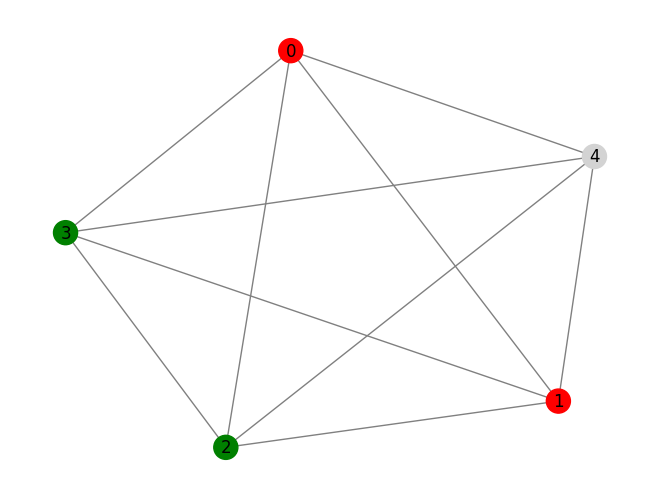

In [433]:
print("Expanded graph coarsened graph")
test_cluster_id_to_color = visualize_clusters(test_expandedGraphData, test_partitioning)

In [446]:
edge_index = test_expandedGraphData.edge_index   # shape [2, E]
edge_attr  = test_expandedGraphData.edge_attr    # shape [E] or [E,1]

for i in range(edge_index.size(1)):
    u = edge_index[0, i].item()
    v = edge_index[1, i].item()
    a = edge_attr[i].item() if edge_attr.ndim == 1 else edge_attr[i,0].item()
    print(f"Edge ({u:2d}, {v:2d})  → attr = {a}")

Edge ( 0,  1)  → attr = 1
Edge ( 0,  2)  → attr = 1
Edge ( 0,  3)  → attr = 1
Edge ( 0,  4)  → attr = 1
Edge ( 1,  0)  → attr = 1
Edge ( 1,  2)  → attr = 1
Edge ( 1,  3)  → attr = 1
Edge ( 1,  4)  → attr = 1
Edge ( 2,  0)  → attr = 1
Edge ( 2,  1)  → attr = 1
Edge ( 2,  3)  → attr = 1
Edge ( 2,  4)  → attr = 1
Edge ( 3,  0)  → attr = 1
Edge ( 3,  1)  → attr = 1
Edge ( 3,  2)  → attr = 1
Edge ( 3,  4)  → attr = 0
Edge ( 4,  0)  → attr = 1
Edge ( 4,  1)  → attr = 1
Edge ( 4,  2)  → attr = 1
Edge ( 4,  3)  → attr = 0


In [434]:
class CoarsenDataset(IterableDataset): # torch dataset
    def __init__(self, graphsDataset, min_red=0.1, max_red=0.3, start=0, end=None):
        super(CoarsenDataset).__init__()
        self.graphsDataset = graphsDataset
        self.min_red, self.max_red = min_red, max_red
        self.start = start
        self.end = len(graphs_dataset) if end is None else end
        
    def __iter__(self):
        iter_start = self.start
        iter_end = self.end
        graphDataset = self.graphsDataset

        selected_graphs = graphDataset[iter_start: iter_end]
        
        for G0 in selected_graphs:
            coarsening_seq, contractions_history = rnd_red_seq(G0, self.min_red, self.max_red)
            # coarsening_seq = [G0, G1, ..., G_L]
            # contractions_history = [P1, P2, ..., P_{L}]  where P_l is used for G_{l-1}->G_l
            
            for G_l, G_lp1, P_l in zip(coarsening_seq[:-1], coarsening_seq[1:], contractions_history):
                yield G_l, G_lp1, P_l # G_l, G_lp1 are graphs, P_l is a tensor


def coarsen_collate(batch):
    G_ls, G_lps, P_ls = zip(*batch)
    batch_G_l   = Batch.from_data_list(G_ls)
    batch_G_lp1 = Batch.from_data_list(G_lps)
    return batch_G_l, batch_G_lp1, list(P_ls)

In [435]:
ds = CoarsenDataset(erdos_renyi_dataset, 0.1, 0.3, start=0, end=100)
loader = torchDataLoader(ds, batch_size=4, collate_fn=coarsen_collate)

for G_l, G_lp1, P_l in loader:
    print("G_l: ", G_l)
    print("G_lp1: ", G_lp1)
    print("P_l is of length: ", len(P_l))
    break

print("\nEach batch contains four graphs:")
for i in range(4):
    print(G_l.get_example(i))

# In a batch all nodes and edge_index are stacked but .batch keeps indices to filter for specific graphs 

G_l:  DataBatch(x=[15, 1], edge_index=[2, 42], batch=[15], ptr=[5])
G_lp1:  DataBatch(x=[10, 1], edge_index=[2, 18], num_nodes=10, batch=[10], ptr=[5])
P_l is of length:  4

Each batch contains four graphs:
Data(x=[5, 1], edge_index=[2, 18])
Data(x=[3, 1], edge_index=[2, 6])
Data(x=[2, 1], edge_index=[2, 2])
Data(x=[5, 1], edge_index=[2, 16])


In [436]:
G_l.batch

tensor([0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3])

In [437]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class SimpleGCN(torch.nn.Module):
    def __init__(self, in_ch, hidden_ch, out_ch):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hidden_ch)
        self.conv2 = GCNConv(hidden_ch, out_ch)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [438]:
model = SimpleGCN(in_ch=1, hidden_ch=16, out_ch=8)
out = model(G_l)
G_l.x = out
graphs = G_l.to_data_list()

In [439]:
graphs[0].x

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SliceBackward0>)

## Define expansion model

In [440]:
import numpy as np
import torch as th
from torch.nn import Module
from torch.nn import functional as F
from torch_geometric.utils import sort_edge_index


class DiscreteGraphDiffusionModel(Module):
    """Preconditioning for discrete diffusion with optional self-conditioning"""

    def __init__(
        self, num_node_categories, num_edge_categories, num_steps
    ):
        super().__init__()
        self.num_node_categories = num_node_categories
        self.num_edge_categories = num_edge_categories
        self.num_steps = num_steps

    def forward(
        self,
        edge_index,
        batch,
        node_attr,
        edge_attr,
        t,
        model,
        model_kwargs,
        node_attr_self_cond=None,
        edge_attr_self_cond=None,
    ):
        # embed node and edge attributes
        node_attr_in = F.one_hot(node_attr, self.num_node_categories).float() * 2 - 1
        edge_attr_in = F.one_hot(edge_attr, self.num_edge_categories).float() * 2 - 1

        node_attr_self_cond = th.zeros_like(node_attr_in)
        edge_attr_self_cond = th.zeros_like(edge_attr_in)

        # concatenate with input
        node_attr_in = th.cat([node_attr_in, node_attr_self_cond], dim=-1)
        edge_attr_in = th.cat([edge_attr_in, edge_attr_self_cond], dim=-1)

        # predict node and edge attributes
        node_pred, edge_pred = model(
            edge_index=edge_index,
            batch=batch,
            node_attr=node_attr_in,
            edge_attr=edge_attr_in,
            **dict(model_kwargs, noise_cond=t.float() / self.num_steps),
        )
        node_pred = node_pred + F.one_hot(node_attr, self.num_node_categories).float()
        edge_pred = edge_pred + F.one_hot(edge_attr, self.num_edge_categories).float()

        return node_pred, edge_pred


class DiscreteGraphDiffusion:
    def __init__(self, self_conditioning, num_steps):
        super().__init__()

        self.model_wrapper = DiscreteGraphDiffusionModel(
            self_conditioning, 2, 2, num_steps
        )
        self.num_steps = num_steps
        self.node_diffusion = CategoricalDiffusion(2, num_steps)
        self.edge_diffusion = CategoricalDiffusion(2, num_steps)

    @property
    def device(self):
        assert hasattr(self, "_device")
        return self._device

    def to(self, device):
        self._device = device
        self.model_wrapper.to(device)
        self.node_diffusion.to(device)
        self.edge_diffusion.to(device)
        return self

    @th.no_grad()
    def sample(self, edge_index, batch, model, model_kwargs):
        """Generate samples using the model.

        Iteratively sample from p(x_{t-1} | x_t) for t = T-1, ..., 0, starting from x_T ~ p(x_T).
        """
        # sample from p(x_T)
        node_attr_t = sample_categorical(self.node_diffusion.qT, batch.size(0))
        edge_triu_mask = edge_index[0] < edge_index[1]
        edge_triu_index = edge_index[:, edge_triu_mask]
        edge_attr_t = sample_categorical(
            self.edge_diffusion.qT, edge_triu_index.size(1)
        )
        edge_attr_t = to_undirected(edge_triu_index, edge_attr_t)[1]

        node_pred = th.zeros(batch.size(0), 2, device=self.device)
        edge_pred = th.zeros(edge_index.size(1), 2, device=self.device)

        bs = batch.max().item() + 1
        # sample from p(x_{t-1} | x_t) for t = T-1, ..., 0
        for timestep in reversed(range(self.num_steps)):
            t = timestep * th.ones(bs, dtype=th.long, device=self.device)

            # predict node and edge attributes
            node_pred, edge_pred = self.model_wrapper(
                edge_index=edge_index,
                batch=batch,
                node_attr=node_attr_t,
                edge_attr=edge_attr_t,
                t=t,
                model=model,
                model_kwargs=model_kwargs,
                node_attr_self_cond=node_pred,
                edge_attr_self_cond=edge_pred,
            )

            # sample ancestor node and edge attributes
            node_attr_t = self.node_diffusion.q_reverse_sample(
                node_attr_t, node_pred, batch, t
            )

            edge_attr_t = self.edge_diffusion.q_reverse_sample(
                edge_attr_t[edge_triu_mask],
                edge_pred[edge_triu_mask],
                batch[edge_triu_index[0]],
                t,
            )
            edge_attr_t = to_undirected(edge_triu_index, edge_attr_t)[1]

        # return probabilities for positive class
        node_out = F.softmax(node_pred, dim=-1)[:, 1]
        edge_out = F.softmax(edge_pred, dim=-1)[:, 1]
        return node_out, edge_out
what about their 
    def get_loss(self, edge_index, batch, node_attr, edge_attr, model, model_kwargs):
        """Compute loss to train the model.

        Sample x_pred ~ p(x_t, t), where t ~ U(0, T-1) and x_t ~ q(x_t | x),
        and compute the cross entropy loss between x_pred and x.
        """
        # sample noisy augmented node and edge attributes
        t = th.randint(0, self.num_steps, (batch.max().item() + 1,), device=self.device)
        node_attr_t = self.node_diffusion.q_sample(node_attr, batch, t)
        edge_triu_mask = edge_index[0] < edge_index[1]
        edge_triu_index = edge_index[:, edge_triu_mask]
        edge_triu_attr = edge_attr[edge_triu_mask]
        edge_triu_batch = batch[edge_index[0, edge_triu_mask]]
        edge_triu_attr_t = self.edge_diffusion.q_sample(
            edge_triu_attr, edge_triu_batch, t
        )
        new_edge_index, edge_attr_t = to_undirected(edge_triu_index, edge_triu_attr_t)
        assert (new_edge_index == edge_index).all()

        # predict
        node_pred, edge_pred = self.model_wrapper(
            edge_index=edge_index,
            batch=batch,
            node_attr=node_attr_t,
            edge_attr=edge_attr_t,
            t=t,
            model=model,
            model_kwargs=model_kwargs,
        )

        # compute loss
        node_loss = self.node_diffusion.get_loss(node_attr, node_pred)
        edge_loss = self.edge_diffusion.get_loss(edge_attr, edge_pred)

        return node_loss, edge_loss


class CategoricalDiffusion(Module):
    """Discrete diffusion for categorical variables.

    Uses a uniform transition matrix with cosine schedule.
    """

    def __init__(self, num_categories, num_steps):
        super().__init__()

        # stable distribution
        qT = np.ones(num_categories) / num_categories

        # cosine schedule (https://arxiv.org/pdf/2102.05379.pdf)
        steps = np.arange(num_steps + 1, dtype=np.float64) / num_steps
        alphas_bar = np.cos((steps + 0.008) / 1.008 * np.pi / 2)
        betas = np.minimum(1 - alphas_bar[1:] / alphas_bar[:-1], 0.999)

        # single step transition matrices
        Qs = (1 - betas)[:, None, None] * np.eye(num_categories) + betas[
            :, None, None
        ] * qT[None, :, None]

        # t-step transition matrices
        Qbs = (
            alphas_bar[:, None, None] * np.eye(num_categories)
            + (1 - alphas_bar)[:, None, None] * qT[None, :, None]
        )

        # register buffers
        self.register_buffer("qT", th.tensor(qT, dtype=th.float64), persistent=False)
        self.register_buffer("Qs", th.tensor(Qs, dtype=th.float64), persistent=False)
        self.register_buffer("Qbs", th.tensor(Qbs, dtype=th.float64), persistent=False)

    def q_sample(self, x, batch, t):
        """Sample from q(x_t | x)."""
        x_t_prob = self.Qbs[t[batch], x]  # N, |x_t|
        return sample_categorical(x_t_prob, 1).squeeze(1)

    def q_reverse_sample(self, x_t, pred, batch, t):
        """Sample from q(x_{t-1} | x_t) = Σ_x q(x_{t-1} | x, x_t) q(x | x_t)."""
        # compute probs of  posterior q(x_{t-1} | x, x_t) ∝ q(x_t | x_{t-1}) q(x_{t-1} | x) for all x
        left_term = self.Qs[t[batch], :, x_t]  # N, |x_{t-1}|
        right_term = self.Qbs[t - 1][batch]  # N, |x|, |x_{t-1}|
        posterior_probs = left_term[:, None, :] * right_term  # N, |x|, |x_t_1|
        posterior_probs = posterior_probs / posterior_probs.sum(-1, keepdim=True)

        # sample from ancestral distribution q(x_{t-1} | x_t)
        x_probs = F.softmax(pred, dim=-1)  # N, |x|
        ancestral_probs = (posterior_probs * x_probs[..., None]).sum(1)  # N, |x_{t-1}|
        return sample_categorical(ancestral_probs, 1).squeeze(1)  # N

    def get_loss(self, x, pred):
        return F.cross_entropy(pred, x, reduction="none")


def to_undirected(edge_index, edge_attr) -> tuple[th.Tensor, th.Tensor]:
    """Convert directed edges to undirected edges."""
    edge_index = th.cat([edge_index, edge_index.flip(0)], dim=1)
    edge_attr = th.cat([edge_attr, edge_attr], dim=0)
    return sort_edge_index(edge_index, edge_attr)


def sample_categorical(probs, num_samples):
    """Sample from a categorical distribution."""

    if num_samples == 0:
        return th.tensor([], dtype=th.long, device=probs.device).view(
            probs.shape[:-1] + (0,)
        )
    else:
        return th.multinomial(probs, num_samples, replacement=True)

SyntaxError: invalid syntax (3767352089.py, line 132)